# Семинар 7 - Линейная регрессия

##### Краткий синопсис:
1. Линейная Регрессия
2. GLM (на примере OLS для нейронауки)
3. RVM 

http://scikit-learn.org/stable/modules/linear_model.html

In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
np.random.seed(42)
warnings.filterwarnings("ignore")

# 1. Линейная регрессия.

### Построим сигнал, который представляет собой модулированную синусоиду

In [9]:
a1 = 10.
a2 = 1.
w1 = 1.
w2 = 12.
N = 256

In [10]:
x = np.linspace(-4, 4, N)
f = a1 * np.sin(w1 * x) + a2 * np.sin(w2 * x)

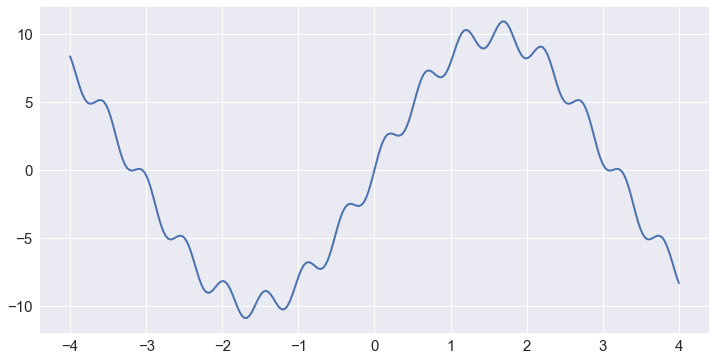

In [11]:
plt.figure(figsize=(12,6))
plt.plot(x, f, linewidth=2)

Сгенерируем оператор, который определяется матрицей $A$ ленточного вида.

Такой оператор соответствует как если бы сигнал обработали moving average, т.е. производит усреднение по некоторому скользящему окну.

In [12]:
A = np.eye(N)
for k in range(1, 15):
    A += np.diag(np.ones(N), k=k)[:N, :N]
    A += np.diag(np.ones(N), k=-k)[:N, :N]

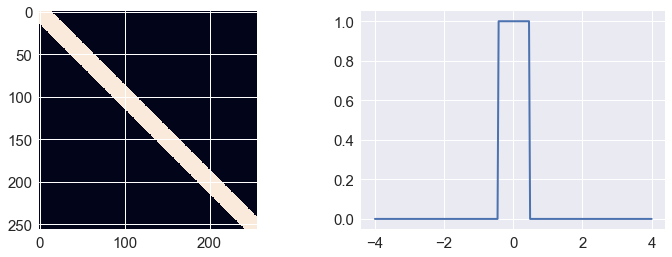

In [13]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].imshow(A)
axs[1].plot(x, A[N // 2,:], linewidth=2)

Сгенерируем выборку $xi$ умножив нашу диагональную матрицу $A$ на наш сигнал $f$.

Т.е. эффективно сгладив сигнал moving average.

In [14]:
sigma = 2
noise = sigma * np.random.randn(N)
xi = np.dot(A, f) + noise

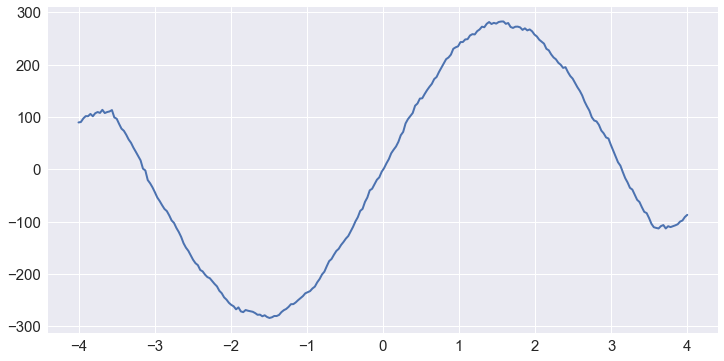

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(x, xi, linewidth=2)

### 1.1 LEAST SQUARES ESTIMATE

Первым делом попробуем восстановить сигнал с помощью LSE, т.е. с помощью метода наименьших квадратов.

$$Af = \xi$$

Матрица псевдорешения(псевдообратная матрица):

$$A^+ = (A^T A)^{-1} A^T$$

Тогда решение можно представить следующим образом:

$$f = A^+ \xi$$

In [17]:
R = np.dot(
        np.linalg.inv(np.dot(A.T, A)),
        A.T
    ) # <YOUR_CODE>
Rxi = np.dot(R, xi)

Text(0.5,1,'Восстановленный сигнала с помощью LSE')

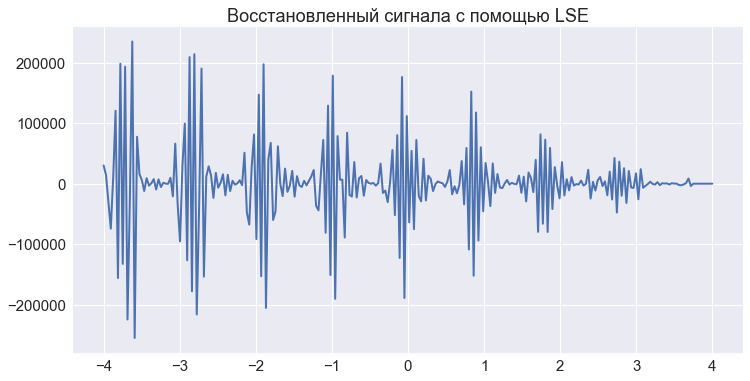

In [18]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi, linewidth=2)
plt.title('Восстановленный сигнала с помощью LSE')

### Wow wow

## WTF?

Наш вариант реализации псевдообратной является неканоничным и страдает из-за плохих собственных значений.
Поэтому лучше использовать специализированные пакеты, которые более эффективно вычисляют псевдообратные матрицы.

https://en.wikipedia.org/wiki/Generalized_inverse

In [24]:
np.linalg.pinv?

In [22]:
R_pinv = np.linalg.pinv(A) # <YOUR_CODE>
R_pinv_xi = np.dot(R_pinv, xi)

Text(0.5,1,'Восстановленный сигнал с помощью np.linalg.pinv')

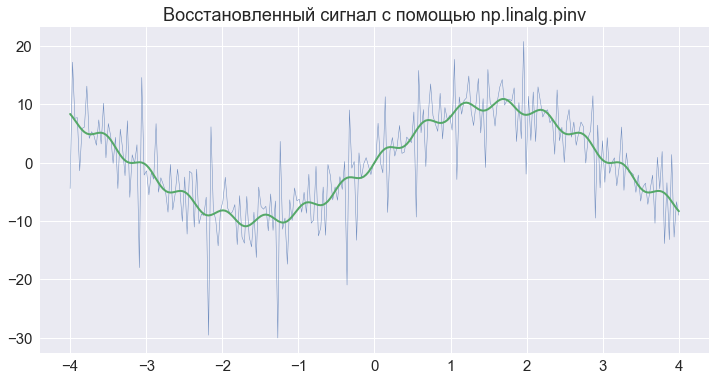

In [23]:
plt.figure(figsize=(12,6))
plt.plot(x, R_pinv_xi, linewidth=0.5, alpha=0.8)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал с помощью np.linalg.pinv')

### NOT QUITE THERE YET. REGULARIZE!

In [29]:
c = 1e-3
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) # <YOUR_CODE>
Rxi_reg = np.dot(R_reg, xi)

Text(0.5,1,'Восстановленный сигнал при включении регуляризации')

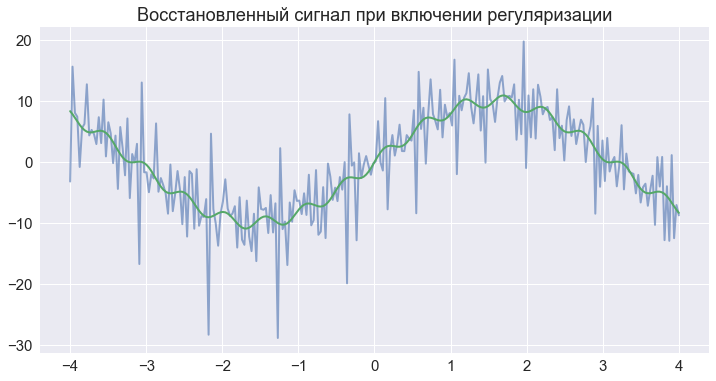

In [30]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

#### Как выбирать коэффициент регуляризации?

In [35]:
reg_coeffs = np.linspace(0.1, 20, 80)
reg_loss = []
for c in reg_coeffs:
    R_reg = np.dot(
            np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
            A.T
        ) # <YOUR_CODE>
    Rxi_reg = np.dot(R_reg, xi)
    loss = np.sum((f - Rxi_reg)**2)
    reg_loss.append(loss)

Text(0.5,1,'MSE в зависимости от коэффициента регуляризации')

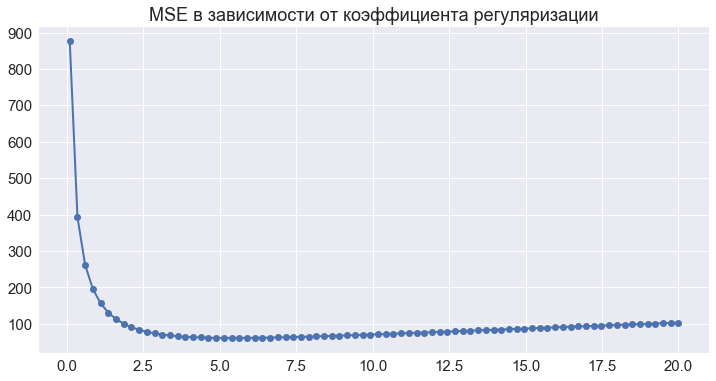

In [36]:
plt.figure(figsize=(12,6))
plt.plot(reg_coeffs, reg_loss, 'o-', linewidth=2)
plt.title('MSE в зависимости от коэффициента регуляризации')

In [39]:
reg_coeffs[np.argmin(reg_loss)]

5.3898734177215175

In [40]:
c = 5.3898
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) # <YOUR_CODE>
Rxi_reg = np.dot(R_reg, xi)

Text(0.5,1,'Восстановленный сигнал при включении регуляризации')

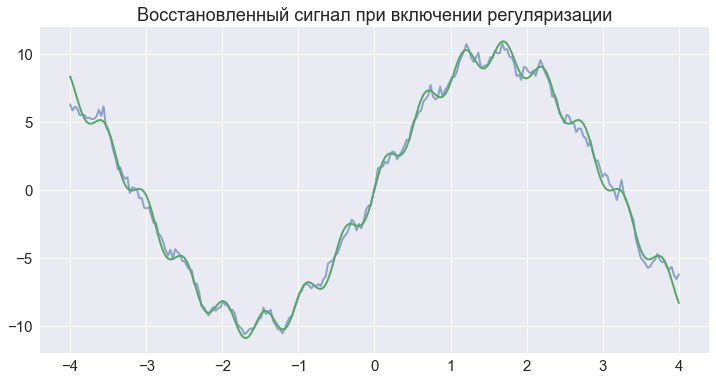

In [41]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

###  SVD

$$A_{n \times m } = U_{m \times m } \Sigma_{m \times n } V_{n \times n }$$

In [43]:
np.linalg.svd?

In [45]:
U, S, V = np.linalg.svd(A)

Text(0.5,1,'Собственные числа оператора A')

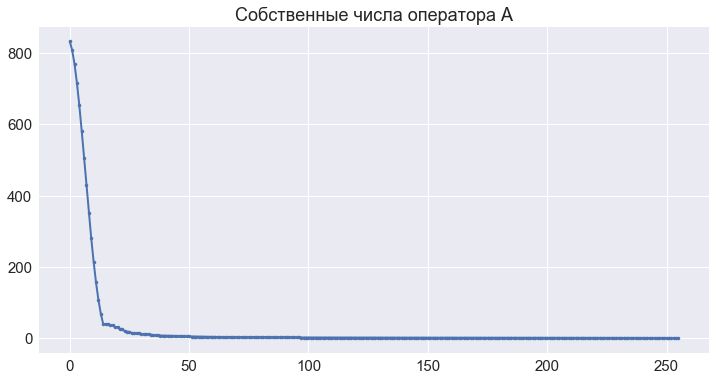

In [46]:
plt.figure(figsize=(12,6))
plt.plot(S**2, '.-', linewidth=2)
plt.title('Собственные числа оператора A')

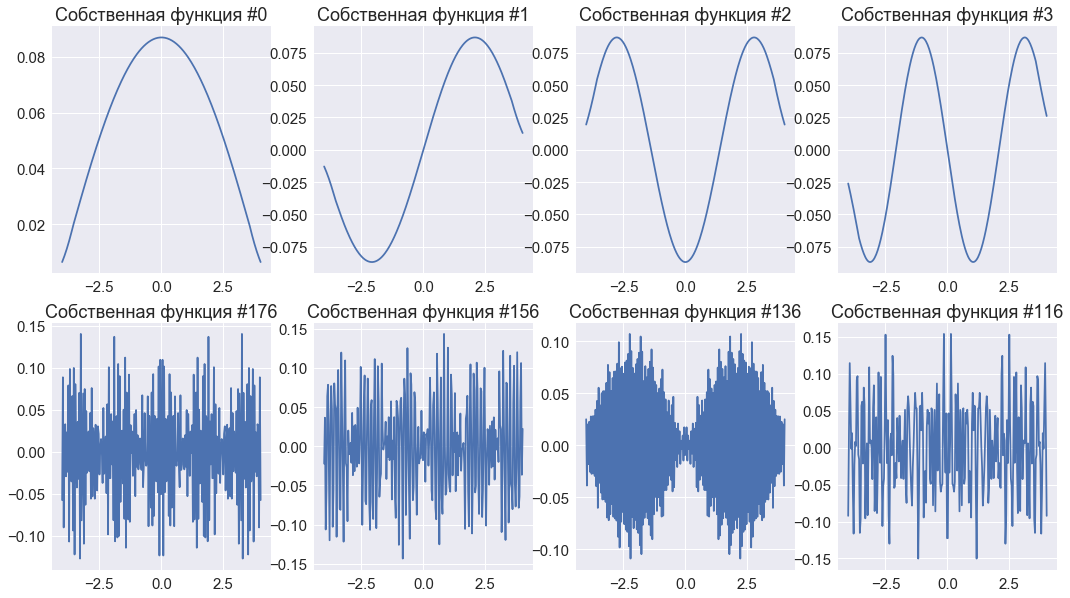

In [50]:
fig, axs = plt.subplots(figsize=(18, 10), ncols=4, nrows=2)
for i in range(4):
    axs[0, i].plot(x, V[i])
    axs[0, i].set_title('Собственная функция #{}'.format(i))
for i in range(4):
    axs[1, i].plot(x, V[N-(4 + i) * 20])
    axs[1, i].set_title('Собственная функция #{}'.format(N-(4 + i) * 20))

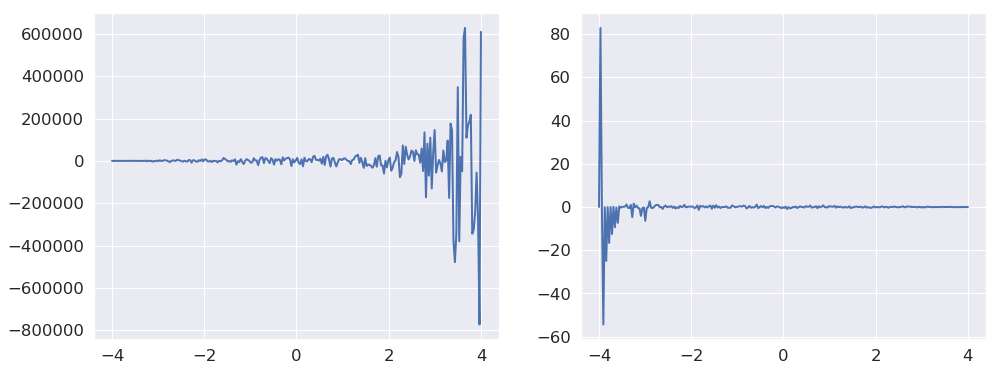

In [24]:
# Отфильтрованный интервал в базисе оператора
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(x, np.dot(V, Rxi), linewidth=2) # <YOUR_CODE>
axs[1].plot(x, np.dot(V, Rxi_reg), linewidth=2) # <YOUR_CODE>

### Переходим к базису оператора A и сделаем все те же самые трюки что делали раньше

Как перейти к базису оператора A имея матрицы $U$, $V$ и $S$?

In [53]:
f_wave = np.dot(V, f) # <YOUR_CODE>
noise_wave = np.dot(V, noise) # <YOUR_CODE>

In [64]:
A_wave = np.diag(S)

In [65]:
xi_wave = np.dot(A_wave, f_wave) + noise_wave

Text(0.5,1,'Отфильтрованный сигнал при переходе ')

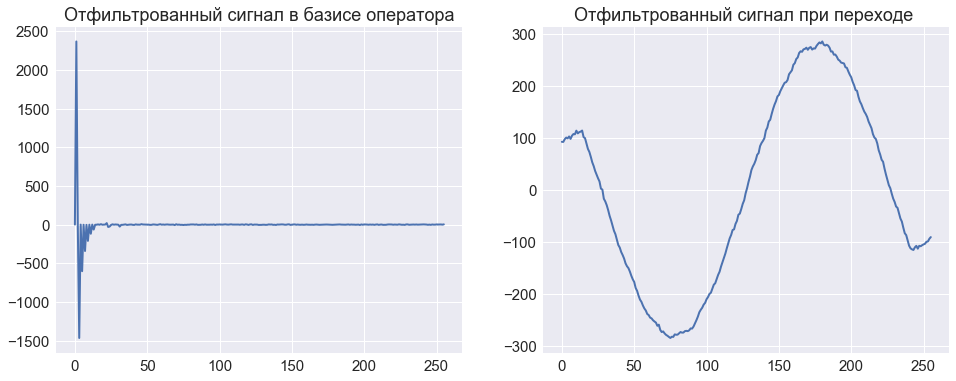

In [66]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)

axs[0].plot(xi_wave, linewidth=2)
axs[0].set_title('Отфильтрованный сигнал в базисе оператора')

# Теперь у нас есть xi_wave -- сигнал в базисе оператора A
# покажем, что это тот самый отфильтрованный сигнал, перейдя обратно в изначальный базис
axs[1].plot(np.dot(V.T, xi_wave), linewidth=2) # <YOUR_CODE>
axs[1].set_title('Отфильтрованный сигнал при переходе ')

А теперь будем будем делать обратные в этом новом базисе.

#Formulae

In [68]:
R_wave = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave)),
        A_wave.T
) # <YOUR_CODE>
R_wave_xi = np.dot(R_wave, xi_wave)

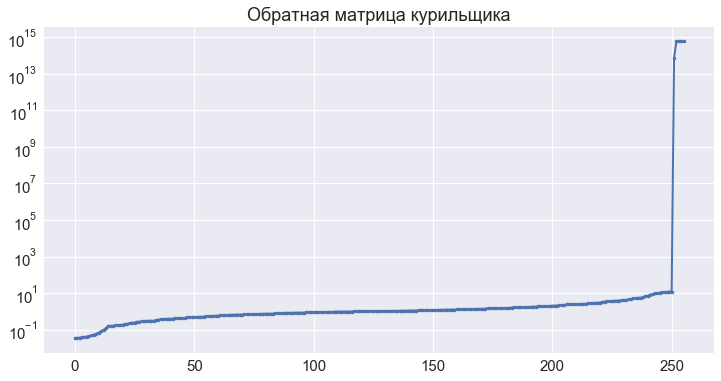

In [77]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_wave), '.-', linewidth=2)
plt.title('Обратная матрица курильщика')
plt.yscale('log')

Text(0.5,1,'Восстановленный сигнал ')

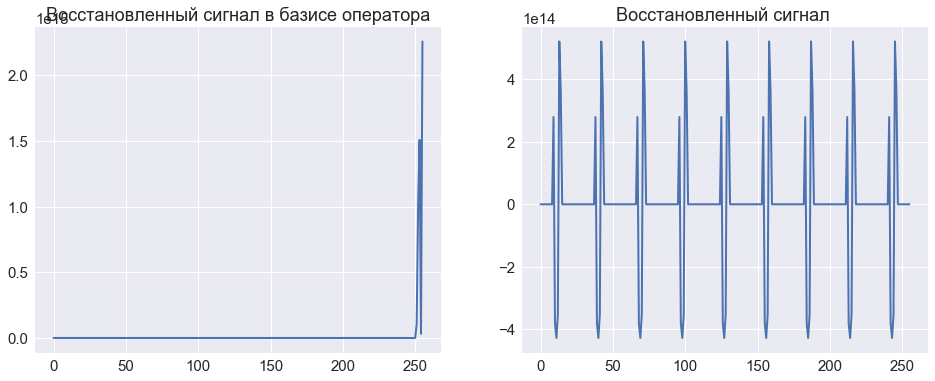

In [78]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(np.dot(V.T, R_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

Опять проблемы с точностью :(

In [80]:
R_pinv_wave = np.linalg.pinv(A_wave)
R_pinv_wave_xi = np.dot(R_pinv_wave, xi_wave)

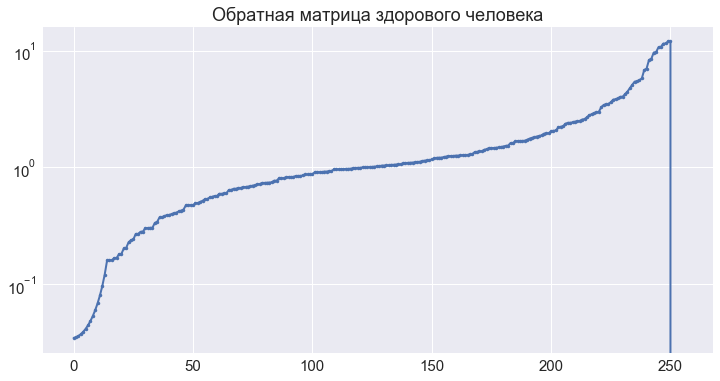

In [81]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_pinv_wave), '.-', linewidth=2)
plt.title('Обратная матрица здорового человека')
plt.yscale('log')

Text(0.5,1,'Восстановленный сигнал ')

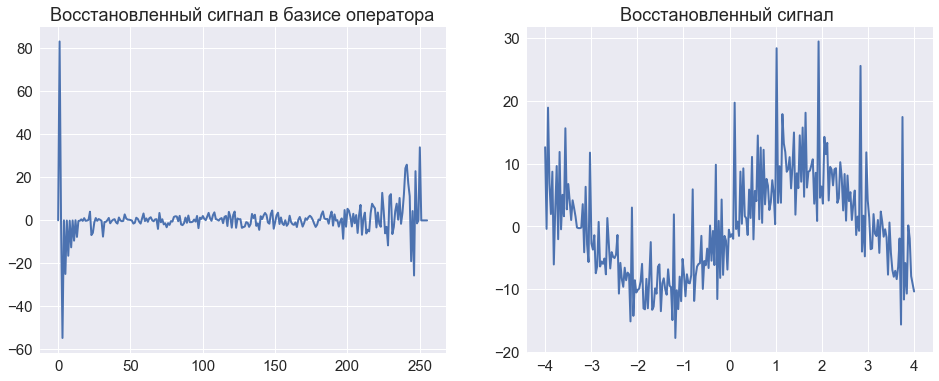

In [82]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_pinv_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(x, np.dot(V.T, R_pinv_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [83]:
c = 5.21
R_wave_reg = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave) + c * np.eye(N)),
        A_wave.T
    ) # <YORE CODE>
R_wave_xi_reg = np.dot(R_wave_reg, xi_wave)

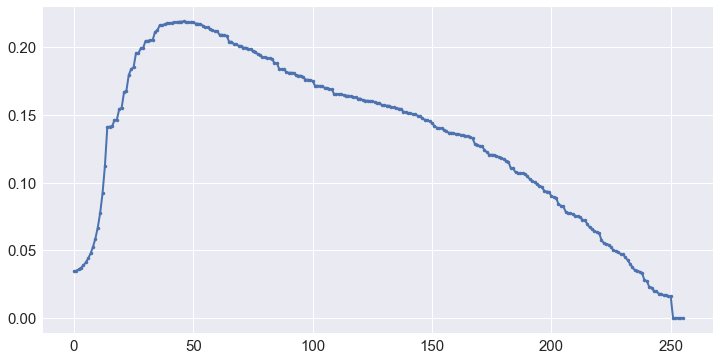

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(np.diag(R_wave_reg), '.-', linewidth=2)

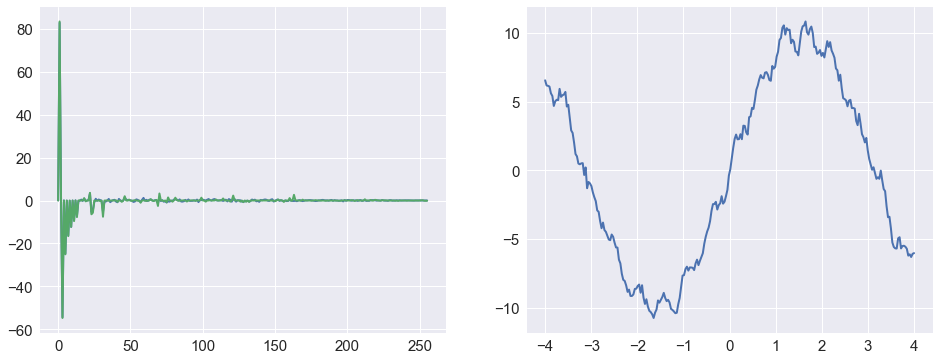

In [85]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi_reg, linewidth=2)
axs[0].plot(f_wave, linewidth=2)
axs[1].plot(x, np.dot(V.T, R_wave_xi_reg), linewidth=2)

#  2. GLM (на примере OLS для нейронауки)

Будем считать пермутационную регессию с МНК (Ordinary Least Squares) для каждого вокселя, чтобы найти области мозга (группы воскелей), которые активируется по-разному algorithm is run at each voxel in order to detemine whether or not it behaves differently under a “face viewing” condition and a “house viewing” condition. We consider the mean image per session and per condition. Otherwise, the observations cannot be exchanged at random because a time dependance exists between observations within a same session (see [1] for more detailed explanations).

The example shows the small differences that exist between Bonferroni-corrected p-values and family-wise corrected p-values obtained from a permutation test combined with a max-type procedure [2]. Bonferroni correction is a bit conservative, as revealed by the presence of a few false negative

Пример из `nilern`: https://nilearn.github.io/decoding/decoding_intro.html

[1] Winkler, A. M. et al. (2014).
Permutation inference for the general linear model. Neuroimage.

[2] Anderson, M. J. & Robinson, J. (2001).
Permutation tests for linear models. Australian & New Zealand Journal of Statistics, 43(1), 75-88. (http://avesbiodiv.mncn.csic.es/estadistica/permut2.pdf)

##### Работаем с данными из датасета Haxby

Haxby et al. (2001): Faces and Objects in Ventral Temporal Cortex (fMRI) - височная кора головного мозга 
https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_stimuli.html

![Датасет](https://www.researchgate.net/profile/Martin_Hebart/publication/270749420/figure/fig2/AS:272567755866138@1441996625521/Results-of-analyses-on-Haxby-2001-data-set-A-Confusion-matrix-reflecting-the-confusion.png)

Brain mapping

https://youtu.be/k61nJkx5aDQ?t=15

In [87]:
!pip install nilearn
import nilearn
import pandas as pd
from nilearn import datasets
from scipy.misc import imread
from nilearn import datasets
from nilearn.plotting import show

distributed 1.21.8 requires msgpack, which is not installed.
tensorflow-tensorboard 0.4.0rc3 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorflow-tensorboard 0.4.0rc3 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
tensorboard 1.7.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorboard 1.7.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
telebot 0.0.3 has requirement requests==2.7.0, but you'll have requests 2.18.4 which is incompatible.
modelgym 0.1.5 has requirement networkx==1.11, but you'll have networkx 2.1 which is incompatible.
modelgym 0.1.5 has requirement scikit-optimize==0.4, but you'll have scikit-optimize 0.5.2 which is incompatible.
eve 0.7.8 has requirement flask<=0.12,>=0.10.1, but you'll have flask 1.0.2 which is incompatible.
eve 0.7.8 has requirement markupsafe<1.0,>=0.23, but you'll have markupsafe 1

In [102]:
#Load Haxby dataset
haxby_dataset = datasets.fetch_haxby(subjects=[2], fetch_stimuli=True)
haxby_dataset.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [103]:
stimulus_information = haxby_dataset.stimuli

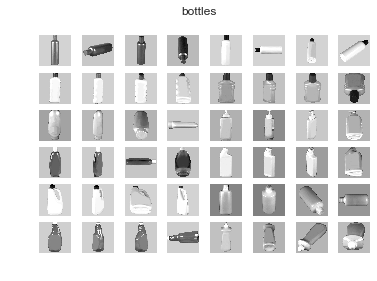

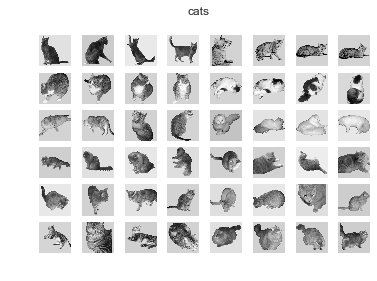

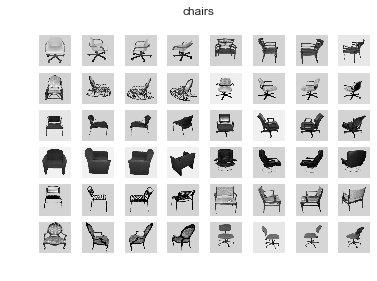

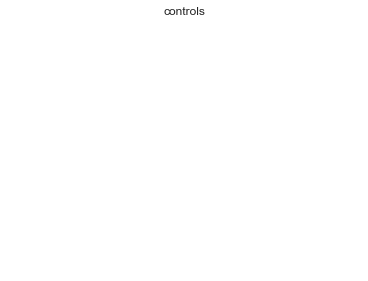

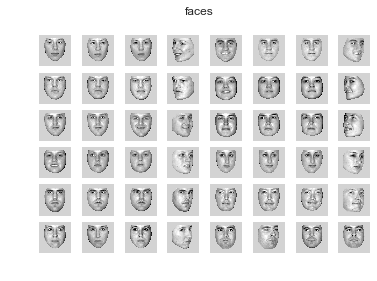

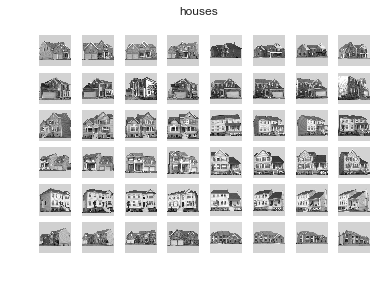

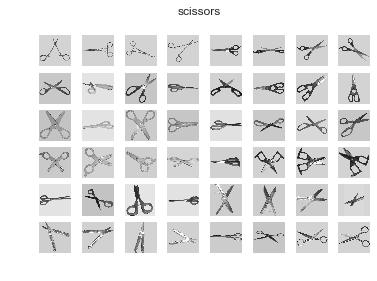

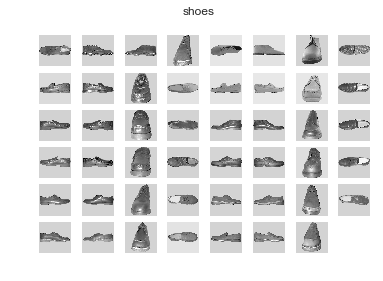

In [104]:
for stim_type in sorted(stimulus_information.keys()):
    if stim_type == b'controls':
        continue
    file_names = stimulus_information[stim_type]
    plt.figure()
    for i in range(48):
        plt.subplot(6, 8, i + 1)
        try:
            plt.imshow(imread(file_names[i]), cmap=plt.cm.gray)
        except:
            pass
        plt.axis("off")
    plt.suptitle(stim_type)
show()

`haxby_dataset.func` содержит картинки мозга в разные моменты времени.

In [105]:
print(haxby_dataset.func[0])
img_temp = nilearn.image.load_img(haxby_dataset.func[0])
print(img_temp.shape)

/home/acappello/nilearn_data/haxby2001/subj2/bold.nii.gz
(40, 64, 64, 1452)


`haxby_dataset.session_target` содержит метки.

In [106]:
print(haxby_dataset.session_target[0])
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']
print(behavioral.shape)
behavioral.head()

/home/acappello/nilearn_data/haxby2001/subj2/labels.txt
(1452, 2)


,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


In [107]:
# Размер одного фмрт изображения, где первые 3 начения это разрешения 3D картинки и 1452 отсчета по времени
print(img_temp.shape)
# И для каждого отсчета известны ключи (визуальные стимулы) для task-based fMRI 
print(conditions.shape)

(40, 64, 64, 1452)
(1452,)


#### Картинка мозга, который выглядит как чужой

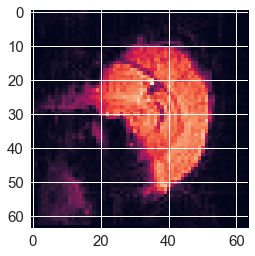

In [108]:
# Воксель - это 3D пиксель. 
# То есть ниже [20,...] -- двухмерный срез пикселей из трехмерного массива, 800 -- отсчет времени
plt.imshow(img_temp.dataobj[20, ..., 800])
# Тут же можно оценить глазами интенсивность каждого вокселя: условно, 
# чем больше крови аккумулируется в данном участке мозга,
# тем интенсивнее сигнал и тем выше активность этого этого региона для каждой когнитивной функции.

![Зачем мы маскируем](http://nilearn.github.io/_images/masking.jpg)

Выберем только нужные вокселы для анализа (домножим 4D массивы на маску): 
Мы работаем уже с предобработанными мозгами в специальном софте: для нас мозги повернули, проскалировали, алайнили друг с другом и натянули на "шаблонный мозг" в специальной координатной системе MNI.

![Mask for fMRI series](https://nilearn.github.io/_images/sphx_glr_plot_visualization_0021.png)

In [109]:
# mask data
mask_filename = haxby_dataset.mask
from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8, mask_img=mask_filename, memory='nilearn_cache', memory_level=1)  # cache options
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)

In [110]:
# Теперь у нас есть 2D массив, который мы и будем использовать в качестве датасета.
# Каждому визуальному ключу ( отсчету времени) соотносятся интенсивности вокселей
# (да, да все воксели кортикальной височной зоны для 1 человека из 6):
print(fmri_masked.shape)
# То есть 
print('Для целикового изображения было бы {}, но мы снизили размерность в 4 раза, наложив маску до 39912'.format(40*64*64))

(1452, 39912)
Для целикового изображения было бы 163840, но мы снизили размерность в 4 раза, наложив маску до 39912


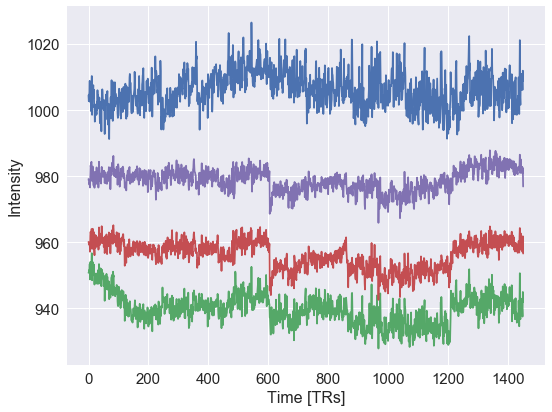

In [111]:
# Посмотрим на то, как изменяется сигнал интенсивности одного вокселя во времени (для 1 человека)
plt.figure(figsize=(8, 6))
plt.plot(fmri_masked[:, 11132:11136])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)
show()

#### Ограничем наши данные домами и лицами

In [112]:
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

conditions = labels['labels']
categories = conditions.unique()
conditions_encoded = np.zeros_like(conditions)

for c, category in enumerate(categories):
    conditions_encoded[conditions == category] = c

sessions = labels['chunks']
condition_mask = conditions.isin(['face', 'house'])
conditions_encoded = conditions_encoded[condition_mask]
fmri_masked = fmri_masked[condition_mask]

# Мы посчитаем, среднее изображение и состояние сессии.
# В противном случае, наблюдения не могут быть обменены в случайном порядке, потому что
# существует зависимость между наблюдениями в рамках одной сессии.
n_sessions = np.unique(sessions).size
grouped_fmri_masked = np.empty((2 * n_sessions,  # two conditions per session
                                fmri_masked.shape[1]))
grouped_conditions_encoded = np.empty((2 * n_sessions, 1))

for s in range(n_sessions):
    session_mask = sessions[condition_mask] == s
    session_house_mask = np.logical_and(session_mask,
                                        conditions[condition_mask] == 'house')
    session_face_mask = np.logical_and(session_mask,
                                       conditions[condition_mask] == 'face')
    grouped_fmri_masked[2 * s] = fmri_masked[session_house_mask].mean(0)
    grouped_fmri_masked[2 * s + 1] = fmri_masked[session_face_mask].mean(0)
    grouped_conditions_encoded[2 * s] = conditions_encoded[
        session_house_mask][0]
    grouped_conditions_encoded[2 * s + 1] = conditions_encoded[
        session_face_mask][0]

In [113]:
# То есть выбрали только для 2х тем ( по 12 сессия каждая) и размерность осталась как у каждого человека
grouped_fmri_masked.shape

(24, 39912)

In [114]:
# Посмотрим на наши ключи:
# визуальные стимулы показывали сессиями chunks по 9 временных отсчетов (временной интервал около 2.5 секунд). 
# можно, кстати, посчитать, что люди лежали в томографе 2.5*1452/3600=1.008 - почти час
# всего сессий было 12.
labels['labels'].value_counts()

rest            588
scissors        108
shoe            108
scrambledpix    108
house           108
bottle          108
chair           108
cat             108
face            108
Name: labels, dtype: int64

Оценим величину корреляции OLS (проверим гипотезу о линейной зависимости/независимости двух сессий  `Дома` и `Лица`).

Посчитаем соответсвующие p-values через two-sided t-test, и тут мы можем посмотреть на знак корреляции.

In [118]:
grouped_conditions_encoded.shape

(24, 1)

In [119]:
grouped_fmri_masked.shape

(24, 39912)

In [127]:
from nilearn.mass_univariate import permuted_ols
permuted_ols?

In [128]:
neg_log_pvals, t_scores_original_data, _ = permuted_ols(tested_vars=grouped_conditions_encoded, 
                                                        target_vars=grouped_fmri_masked,
                                                        n_perm=10000, two_sided_test=True,
                                                        n_jobs=-1)

signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)

signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(signed_neg_log_pvals)

Посчитаем scikit-learn F-scores для сравнения.

Одномерные линейные тесты регрессии.

Линейная модель для тестирования индивидуального эффекта каждого из многих регрессоров.
F-test не позволяет оценивать знак эффекта(pure two-sided test); по F-score восстанавливается p-value

In [129]:
from sklearn.feature_selection import f_regression
f_regression?

In [134]:
_, pvals_bonferroni = f_regression(X=grouped_fmri_masked, y=grouped_conditions_encoded)
# Давайте попробуем убрать эту коррекцию на множественное сравнение
pvals_bonferroni *= fmri_masked.shape[1] # Корреция на множественное сравнение (FDR) - Bonferroni to death
pvals_bonferroni[np.isnan(pvals_bonferroni)] = 1
pvals_bonferroni[pvals_bonferroni > 1] = 1
neg_log_pvals_bonferroni = -np.log10(pvals_bonferroni)
neg_log_pvals_bonferroni_unmasked = nifti_masker.inverse_transform(neg_log_pvals_bonferroni)

In [ ]:
mean_fmri_img

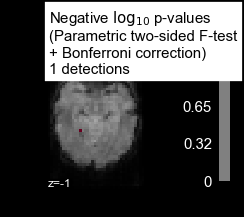

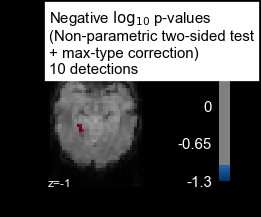

In [135]:
from nilearn.plotting import plot_stat_map, show

# Сконкатим все мозги, чтобы построить воксели на "усредненном" изображении
from nilearn import image
mean_fmri_img = image.mean_img(func_filename)

threshold = -np.log10(0.1)  # Попробуем тут эмпирический трешхолд 10% corrected

vmax = min(signed_neg_log_pvals.max(),
           neg_log_pvals_bonferroni.max())

# Plot thresholded p-values map corresponding to F-scores
display = plot_stat_map(neg_log_pvals_bonferroni_unmasked, mean_fmri_img,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[-1, ],
                        vmax=vmax)

neg_log_pvals_bonferroni_data = neg_log_pvals_bonferroni_unmasked.get_data()
n_detections = (neg_log_pvals_bonferroni_data > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Parametric two-sided F-test'
         '\n+ Bonferroni correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.1)

#  Карта с регрессионного анализа и соответсвующие p-values с МНК (OLS) анализа
display = plot_stat_map(signed_neg_log_pvals_unmasked, mean_fmri_img,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[-1, ],
                        vmax=vmax)

n_detections = (np.abs(signed_neg_log_pvals) > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric two-sided test'
         '\n+ max-type correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.1)

show()

### Усилимся и подключим машинку, допустим метод опорных векторов (SVM)

Будем увеличивать точность классификации и попробуем классфицировать все объекты

In [136]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from collections import defaultdict
from tqdm import tqdm

In [137]:
stimuli = labels['labels']
# Уберем сессии resting state -без визуального стимула
task_mask = (stimuli != 'rest')
# Создадим список названий стимулов
categories = stimuli[task_mask].unique()
# И сохраним лейблы для каждой из 12 сессий 
session_labels = labels["chunks"][task_mask]

In [143]:
# Будем классификацировать сессии методом опорных векторов
svc = SVC(C=1., kernel="linear")
lr = LogisticRegression()
dummy = DummyClassifier()

In [1]:
# Мы снизим размерность данных, домножив каждый мозг на бинарную маску, которую мы получили выше
# В этой маске например только 30 вокселей со значением 1.
mask_name='mask_house'
print(nilearn.image.load_img(haxby_dataset[mask_name][0]).shape)
plt.imshow(nilearn.image.load_img(haxby_dataset[mask_name][0]).dataobj[30,...])

NameError: name 'nilearn' is not defined

И возьмем ещё маску `vt` - которая заключает в себе все вокселы височной теменной зоны

(40, 64, 64)


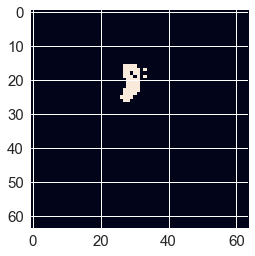

In [139]:
# В этой маске 482 ненулевых вокселя
mask_name='mask_vt'
print(nilearn.image.load_img(haxby_dataset[mask_name][0]).shape)
plt.imshow(nilearn.image.load_img(haxby_dataset[mask_name][0]).dataobj[30,...])

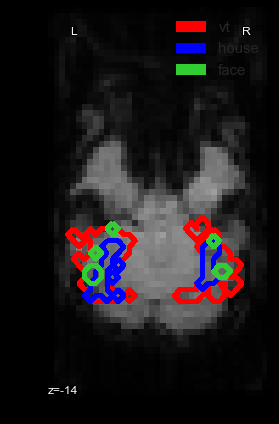

In [140]:
# Так мы получаем маски, или же определяем функциональные зоны мозга, ответсвенные за обработку конкретной информации
from nilearn import image
func_filename = haxby_dataset.func[0]
mean_img = image.mean_img(func_filename)

z_slice = -14

fig = plt.figure(figsize=(4, 5.4), facecolor='k')

from nilearn.plotting import plot_anat, show
display = plot_anat(mean_img, display_mode='z', cut_coords=[z_slice],
                    figure=fig)
mask_vt_filename = haxby_dataset.mask_vt[0]
mask_house_filename = haxby_dataset.mask_house[0]
mask_face_filename = haxby_dataset.mask_face[0]
display.add_contours(mask_vt_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['red'])
display.add_contours(mask_house_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['blue'])
display.add_contours(mask_face_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['limegreen'])

from matplotlib.patches import Rectangle
p_v = Rectangle((0, 0), 1, 1, fc="red")
p_h = Rectangle((0, 0), 1, 1, fc="blue")
p_f = Rectangle((0, 0), 1, 1, fc="limegreen")
plt.legend([p_v, p_h, p_f], ["vt", "house", "face"])

show()

А теперь посмотрим, сможем ли мы определить по фМРТ, о чем думает/что видит человек, и с какой точностью мы это определяем.

In [144]:
# Будем классифицировать по отдельным людям и по 12 сессиям отдельно.

cv = 10

mask_names = ['mask_vt', 'mask_face', 'mask_house']

svc_scores = defaultdict(lambda: defaultdict(float))
lr_scores = defaultdict(lambda: defaultdict(float))
dummy_scores = defaultdict(lambda: defaultdict(float))

for mask_name in tqdm(mask_names):
    print("Working on mask %s" % mask_name)
    mask_filename = haxby_dataset[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    masked_timecourses = masker.fit_transform(func_filename)[task_mask]
    classification_target = (stimuli[task_mask] == category)
    print(masked_timecourses.shape, classification_target.shape)

    for category in tqdm(categories):
        print("Processing %s %s" % (mask_name, category))
        classification_target = (stimuli[task_mask] == category)
        svc_scores[mask_name][category] = cross_val_score(estimator=svc, X=masked_timecourses,
                                                          y=classification_target, cv=cv, 
                                                          groups=session_labels, scoring="roc_auc")

        lr_scores[mask_name][category] = cross_val_score(estimator=lr, X=masked_timecourses,
                                                         y=classification_target, cv=cv, 
                                                         groups=session_labels, scoring="roc_auc")

        dummy_scores[mask_name][category] = cross_val_score(estimator=dummy, X=masked_timecourses,
                                                            y=classification_target, cv=cv, 
                                                            groups=session_labels, scoring="roc_auc")


  0%|          | 0/3 [00:00<?, ?it/s]

Working on mask mask_vt




  0%|          | 0/8 [00:00<?, ?it/s]

(864, 464) (864,)
Processing mask_vt scissors



 12%|█▎        | 1/8 [00:02<00:19,  2.78s/it]

Processing mask_vt face



 25%|██▌       | 2/8 [00:05<00:16,  2.68s/it]

Processing mask_vt cat



 38%|███▊      | 3/8 [00:08<00:14,  2.86s/it]

Processing mask_vt shoe



 50%|█████     | 4/8 [00:12<00:12,  3.20s/it]

Processing mask_vt house



 62%|██████▎   | 5/8 [00:15<00:09,  3.07s/it]

Processing mask_vt scrambledpix



 75%|███████▌  | 6/8 [00:17<00:05,  2.88s/it]

Processing mask_vt bottle



 88%|████████▊ | 7/8 [00:20<00:02,  2.89s/it]

Processing mask_vt chair



 33%|███▎      | 1/3 [00:35<01:10, 35.48s/it]

Working on mask mask_face



  0%|          | 0/8 [00:00<?, ?it/s]

(864, 30) (864,)
Processing mask_face scissors



 12%|█▎        | 1/8 [00:00<00:01,  3.78it/s]

Processing mask_face face



 25%|██▌       | 2/8 [00:00<00:01,  3.70it/s]

Processing mask_face cat



 38%|███▊      | 3/8 [00:00<00:01,  3.71it/s]

Processing mask_face shoe



 50%|█████     | 4/8 [00:01<00:01,  3.83it/s]

Processing mask_face house



 62%|██████▎   | 5/8 [00:01<00:00,  3.85it/s]

Processing mask_face scrambledpix



 75%|███████▌  | 6/8 [00:01<00:00,  3.77it/s]

Processing mask_face bottle



 88%|████████▊ | 7/8 [00:01<00:00,  3.86it/s]

Processing mask_face chair



 67%|██████▋   | 2/3 [00:49<00:28, 28.99s/it]

Working on mask mask_house



  0%|          | 0/8 [00:00<?, ?it/s]

(864, 118) (864,)
Processing mask_house scissors



 12%|█▎        | 1/8 [00:01<00:10,  1.50s/it]

Processing mask_house face



 25%|██▌       | 2/8 [00:02<00:07,  1.32s/it]

Processing mask_house cat



 38%|███▊      | 3/8 [00:03<00:06,  1.33s/it]

Processing mask_house shoe



 50%|█████     | 4/8 [00:05<00:05,  1.33s/it]

Processing mask_house house



 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

Processing mask_house scrambledpix



 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

Processing mask_house bottle



 88%|████████▊ | 7/8 [00:08<00:01,  1.16s/it]

Processing mask_house chair



100%|██████████| 3/3 [01:11<00:00, 26.84s/it]


In [147]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [148]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [149]:
from skbayes.rvm_ard_models import RVR
from sklearn.linear_model import LinearRegression
N = 200

In [150]:
x = np.linspace(-5, 5, N)
X = np.vstack([
    x, 
    np.cos(x),
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
    np.random.randn(N) / 10
]).T
Y = 10 * np.sinc(x) + np.random.randn(N)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

Y_test = Y_test[np.argsort(X_test[:, 0])]
X_test = X_test[np.argsort(X_test[:, 0])]

In [151]:
rvm = RVR(kernel='linear')
rvm.fit(X_train, Y_train)

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [152]:
Y_pred_rvm, Y_pred_std = rvm.predict_dist(X_test)
Y_pred_lr = lr.predict(X_test)

mean_squared_error(Y_pred_rvm, Y_test), mean_squared_error(Y_pred_lr, Y_test)

(5.942330547929795, 5.987629290159988)

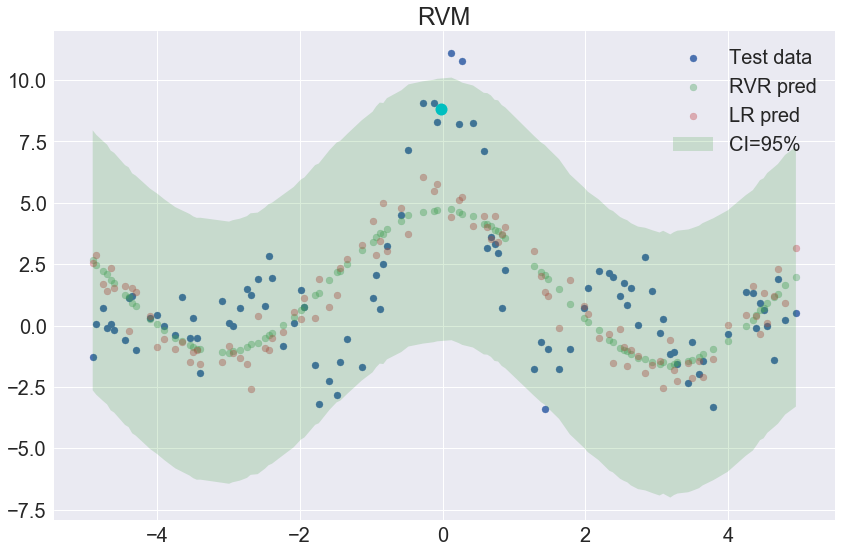

In [153]:
plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "Test data")
plt.scatter(X_test[:, 0], Y_pred_rvm, label = "RVR pred", alpha=0.4)
plt.scatter(X_test[:, 0], Y_pred_lr, label = "LR pred", alpha=0.4)
plt.fill_between(X_test[:, 0], 
                 Y_pred_rvm - 2 * np.sqrt(Y_pred_std), 
                 Y_pred_rvm + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.plot(rvm.relevant_vectors_[:, 0], Y_train[rvm.active_], "co", markersize = 12)
plt.legend()
plt.title("RVM")
plt.show()

### Bias-Variance decomposition

$$\bar{y} = \frac{1}{N} \sum \hat{y}_i$$

$$bias^2=MSE(y, \bar{y})$$

$$variance=\frac{1}{N} \sum MSE(\hat{y}_i, \bar{y})$$

In [154]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm

In [155]:
bias_rvr = []
variance_rvr = []
error_rvr = []

bias_lr = []
variance_lr = []
error_lr = []

degrees = np.arange(1, 10)
resamples = 20

for degree in tqdm(degrees):
    
    Y_preds_rvr = []
    Y_preds_lr = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        rvm = RVR(kernel='poly', degree=degree).fit(X_train_resample, Y_train_resample)
        Y_pred_rvr = rvm.predict(X_test)
        Y_preds_rvr.append(Y_pred_rvr)
        
        lr = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                       ('linear', LinearRegression(fit_intercept=False, n_jobs=-1))])
        lr.fit(X_train_resample, Y_train_resample)
        Y_pred_lr = lr.predict(X_test)
        Y_preds_lr.append(Y_pred_lr)

        
    Y_preds_rvr = np.array(Y_preds_rvr)
    bias_rvr.append(
        ((Y_preds_rvr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_rvr.append(
        ((Y_preds_rvr - Y_preds_rvr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_rvr.append(
        ((Y_preds_rvr - Y_test)**2).mean(axis=1).mean()
    )
    
    Y_preds_lr = np.array(Y_preds_lr)
    bias_lr.append(
        ((Y_preds_lr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_lr.append(
        ((Y_preds_lr - Y_preds_lr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_lr.append(
        ((Y_preds_lr - Y_test)**2).mean(axis=1).mean()
    )
    
bias_rvr = np.array(bias_rvr)
variance_rvr = np.array(variance_rvr)
error_rvr = np.array(error_rvr)

bias_lr = np.array(bias_lr)
variance_lr = np.array(variance_lr)
error_lr = np.array(error_lr)

100%|██████████| 9/9 [00:08<00:00,  1.11s/it]


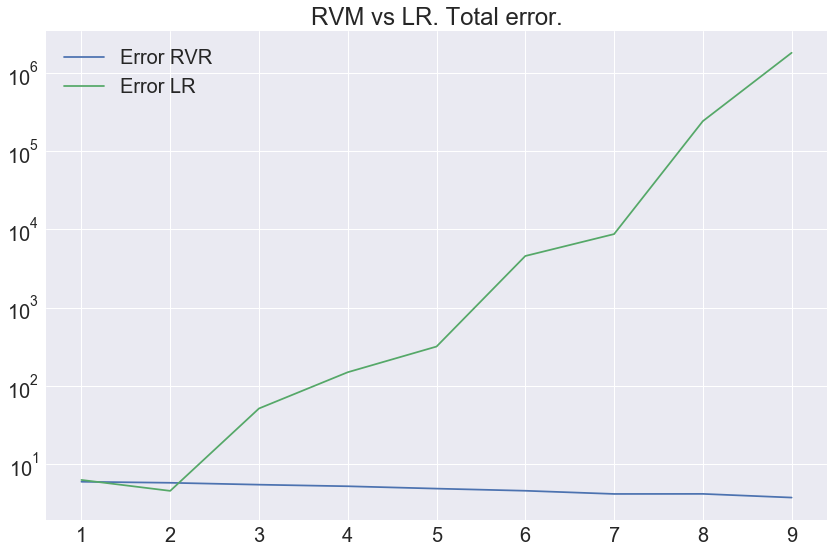

In [156]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, error_rvr, label='Error RVR')
plt.plot(degrees, error_lr, label='Error LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total error.")
plt.show()

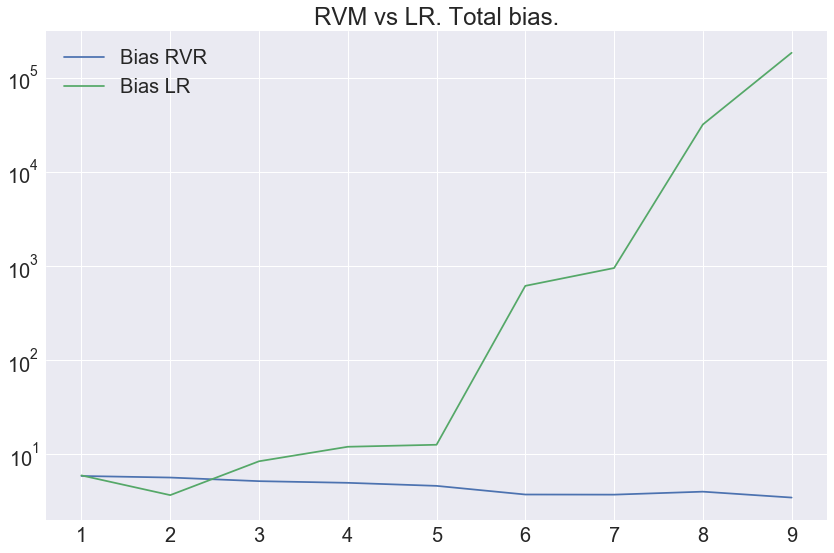

In [157]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, bias_rvr, label='Bias RVR')
plt.plot(degrees, bias_lr, label='Bias LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total bias.")
plt.show()

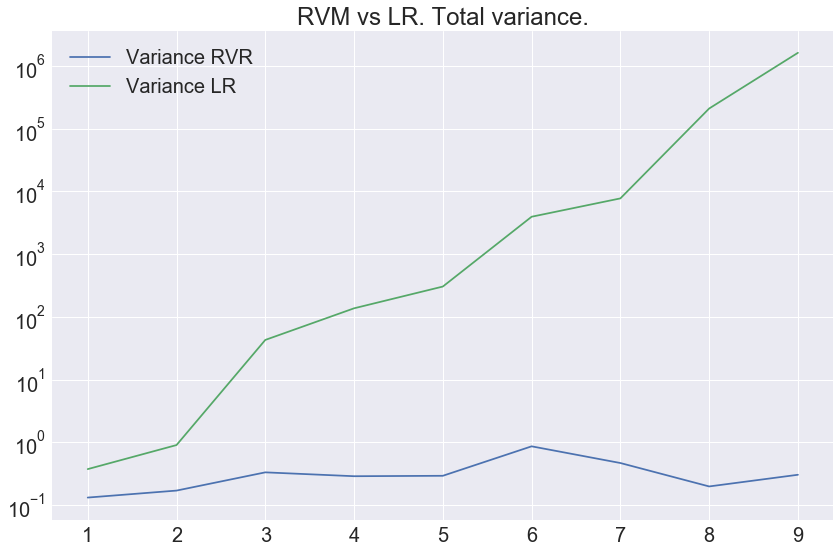

In [158]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, variance_rvr, label='Variance RVR')
plt.plot(degrees, variance_lr, label='Variance LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total variance.")
plt.show()

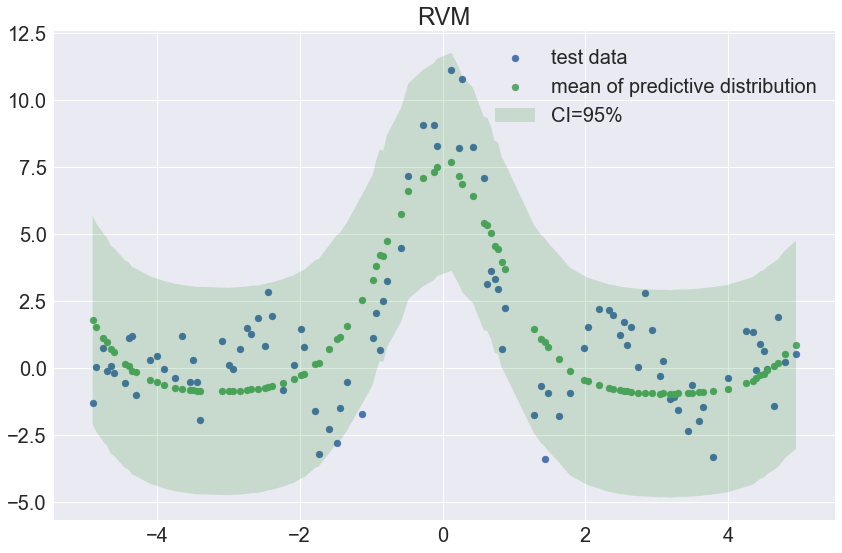

In [159]:
rvm = RVR(kernel='poly', degree=9).fit(X_train, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(X_test)

plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()

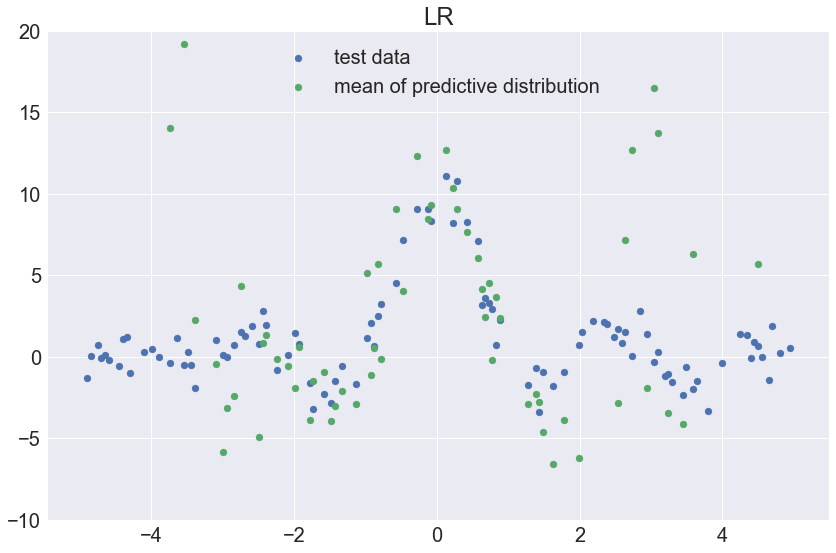

In [164]:
lr = Pipeline([('poly', PolynomialFeatures(degree=9)),
               ('linear', LinearRegression(fit_intercept=False, n_jobs=-1))]).fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.ylim(-10, 20)

plt.legend()
plt.title("LR")
plt.show()